In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
tf.random.set_seed(43)
np.random.seed(43)

## Building the training dataset.
Let's look at the train image list

In [3]:
import os

path = "../input/ultrasound-nerve-segmentation/train/"
file_list = os.listdir(path)
file_list[:20]

['35_63_mask.tif',
 '34_68_mask.tif',
 '22_46.tif',
 '26_80_mask.tif',
 '34_6_mask.tif',
 '13_43.tif',
 '22_34_mask.tif',
 '25_102_mask.tif',
 '13_110_mask.tif',
 '23_60.tif',
 '43_79_mask.tif',
 '29_114_mask.tif',
 '5_29_mask.tif',
 '26_60.tif',
 '44_42.tif',
 '46_66_mask.tif',
 '43_53_mask.tif',
 '7_74.tif',
 '32_114.tif',
 '27_103.tif']

**Sort the file list in ascending order and seperate it into images and masks**<br/>
Each file has the form of either "subject_imageNum.tif" or "subject_imageNum_mask.tif", so we can extract `subject` and `imageNum` from each file name by using regular expression. `"[0-9]+"` means to find the first consecutive number.<br/>

In [4]:
train_image = []
train_mask = glob(path + '*_mask*')

for i in train_mask:
    train_image.append(i.replace('_mask', ''))
        
print(train_image[:10],"\n" ,train_mask[:10])

['../input/ultrasound-nerve-segmentation/train/35_63.tif', '../input/ultrasound-nerve-segmentation/train/34_68.tif', '../input/ultrasound-nerve-segmentation/train/26_80.tif', '../input/ultrasound-nerve-segmentation/train/34_6.tif', '../input/ultrasound-nerve-segmentation/train/22_34.tif', '../input/ultrasound-nerve-segmentation/train/25_102.tif', '../input/ultrasound-nerve-segmentation/train/13_110.tif', '../input/ultrasound-nerve-segmentation/train/43_79.tif', '../input/ultrasound-nerve-segmentation/train/29_114.tif', '../input/ultrasound-nerve-segmentation/train/5_29.tif'] 
 ['../input/ultrasound-nerve-segmentation/train/35_63_mask.tif', '../input/ultrasound-nerve-segmentation/train/34_68_mask.tif', '../input/ultrasound-nerve-segmentation/train/26_80_mask.tif', '../input/ultrasound-nerve-segmentation/train/34_6_mask.tif', '../input/ultrasound-nerve-segmentation/train/22_34_mask.tif', '../input/ultrasound-nerve-segmentation/train/25_102_mask.tif', '../input/ultrasound-nerve-segmentati

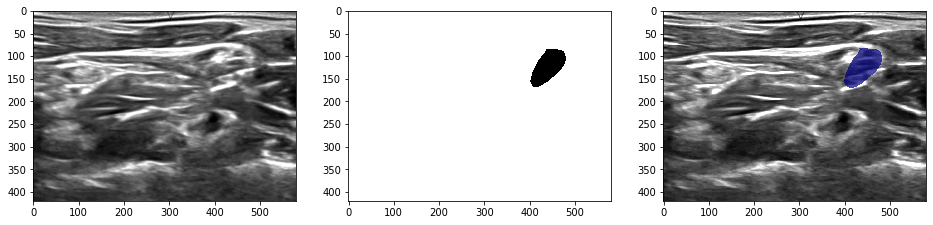

In [5]:
# Display the first image and mask of the first subject.
image1 = np.array(Image.open(path+"1_1.tif"))
image1_mask = np.array(Image.open(path+"1_1_mask.tif"))
image1_mask = np.ma.masked_where(image1_mask == 0, image1_mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

Now, I try to load all image files and store them variables X and y. Afther doing this, I recognize that it takes very much memory.<br/>
Please let me know if there are several efficient ways to store image file

## How to deal with train_masks.csv ?

In [6]:
width = 128
height = 128

Let's check that I did well

Let's modularize this work.

In [7]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate,add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy, MSE

In [8]:
def dice_coef(y_true, y_pred, smooth = 1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth = 1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f) + smooth
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f) + smooth

    return intersection/union

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bbox_loss(y_true, y_pred):
    y_cls = K.sum(y_true, axis=-1)
    
    loss = K.mean(K.square(y_true - y_pred), axis=-1)
    loss = loss * y_cls
    return loss

def cgm_loss(y_true, y_pred):
    y_tr_cls = y_true[:, 0]
    y_tr_bb = y_true[:, 1:]
    y_pr_cls = y_pred[:, 0]
    y_pr_bb = y_pred[:, 1:]
    
    return binary_crossentropy(y_tr_cls, y_pr_cls) + MSE(y_tr_bb, y_pr_bb) * y_tr_cls

# From : https://github.com/symoon94/YOLO-keras/blob/master/yolo2/loss.py
def box_diou(b_true, b_pred):
    """
    Calculate DIoU/CIoU loss on anchor boxes
    Reference Paper:
        "Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression"
        https://arxiv.org/abs/1911.08287
    Parameters
    ----------
    b_true: GT boxes tensor, shape=(batch, feat_w, feat_h, anchor_num, 4), xywh
    b_pred: predict boxes tensor, shape=(batch, feat_w, feat_h, anchor_num, 4), xywh
    use_ciou: bool flag to indicate whether to use CIoU loss type
    Returns
    -------
    diou: tensor, shape=(batch, feat_w, feat_h, anchor_num, 1)
    """
    b_true_xy = b_true[:, :2]
    b_true_wh = b_true[:, 2:4]
    b_true_wh_half = b_true_wh/2.
    b_true_mins = b_true_xy - b_true_wh_half
    b_true_maxes = b_true_xy + b_true_wh_half

    b_pred_xy = b_pred[:, :2]
    b_pred_wh = b_pred[:, 2:4]
    b_pred_wh_half = b_pred_wh/2.
    b_pred_mins = b_pred_xy - b_pred_wh_half
    b_pred_maxes = b_pred_xy + b_pred_wh_half

    intersect_mins = K.maximum(b_true_mins, b_pred_mins)
    intersect_maxes = K.minimum(b_true_maxes, b_pred_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[:, 0] * intersect_wh[:, 1]
    b_true_area = b_true_wh[:, 0] * b_true_wh[:, 1]
    b_pred_area = b_pred_wh[:, 0] * b_pred_wh[:, 1]
    union_area = b_true_area + b_pred_area - intersect_area
    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = intersect_area / (union_area + K.epsilon())

    # box center distance
    center_distance = K.sum(K.square(b_true_xy - b_pred_xy), axis=-1)
    # get enclosed area
    enclose_mins = K.minimum(b_true_mins, b_pred_mins)
    enclose_maxes = K.maximum(b_true_maxes, b_pred_maxes)
    enclose_wh = K.maximum(enclose_maxes - enclose_mins, 0.0)
    # get enclosed diagonal distance
    enclose_diagonal = K.sum(K.square(enclose_wh), axis=-1)
    # calculate DIoU, add epsilon in denominator to avoid dividing by 0
    diou = iou - 1.0 * (center_distance) / (enclose_diagonal + K.epsilon())
    
    return diou

In [9]:
# !rmdir /Q /S ..\ultrasound\generated

In [10]:
pos_mask = []
pos_img = []
neg_mask = []
neg_img = []

for mask_path, img_path in zip(train_mask, train_image):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if np.sum(mask) == 0:
        neg_mask.append(mask_path)
        neg_img.append(img_path)
    else:
        pos_mask.append(mask_path)
        pos_img.append(img_path)

In [11]:
!mkdir generated
!mkdir generated/img

In [12]:
def flip_up_down(img):
    newImg = img.copy()
    return cv2.flip(newImg, 0)

def flip_right_left(img):
    newImg = img.copy()
    return cv2.flip(newImg, 1)

In [13]:
gen_img = []
gen_mask = []

for (img_path, mask_path) in tqdm(zip(pos_img, pos_mask)):
    image_name = img_path.split('/')[-1].split('.')[0]

    uf_img_path = 'generated/img/'+image_name+'_uf.jpg'
    uf_mask_path = 'generated/img/'+image_name+'_uf_mask.jpg'
    rf_img_path = 'generated/img/'+image_name+'_rf.jpg'
    rf_mask_path = 'generated/img/'+image_name+'_rf_mask.jpg'

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    uf_img = flip_up_down(img)
    uf_mask = flip_up_down(mask)
    cv2.imwrite(uf_img_path, uf_img)
    cv2.imwrite(uf_mask_path, uf_mask)
    
    rf_img = flip_right_left(img)
    rf_mask = flip_right_left(mask)
    cv2.imwrite(rf_img_path, rf_img)
    cv2.imwrite(rf_mask_path, rf_mask)
    
    gen_img.append(uf_img_path)
    gen_mask.append(uf_mask_path)
    gen_img.append(rf_img_path)
    gen_mask.append(rf_mask_path)

2323it [01:24, 27.47it/s]


In [14]:
intruders = []

try:
    with open('intruders.dat', 'rb') as f:
        intruders = pickle.load(f)
except FileNotFoundError:
    pos_images = np.array([cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in pos_img])
    
    for im_path in tqdm(neg_img):
        neg = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)

        comp = pos_images == neg
        for i, j in enumerate(comp):
            if j.all():
                # print(im_path.replace('\\', '\\\\'))
                intruders.append(im_path)
                break
    
    with open('intruders.dat', 'wb') as f:
        pickle.dump(intruders, f)

100%|██████████| 3312/3312 [11:43<00:00,  4.71it/s]


In [15]:
## Throwing away False Negative from dataset

train_image_polished = train_image.copy()
train_mask_polished = train_mask.copy()

for i in intruders:
    index = train_image.index(i)
    train_image_polished.pop(index)
    train_mask_polished.pop(index)

In [16]:
aug_img = gen_img + train_image_polished
aug_mask = gen_mask + train_mask_polished

df_ = pd.DataFrame(data={"filename": aug_img, 'mask' : aug_mask})
df = df_.sample(frac=1).reset_index(drop=True)

kf = KFold(n_splits = 5, shuffle=False)

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *

def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

# def res_path(inputs,filter_size,path_number):
#     """
#     res_path -- residual path / modified skip connection
    
#     Arguments:
#     inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
#     filter_size {int} -- convolutional filter size 
#     path_number {int} -- path identifier 
    
#     Returns:
#     skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
#     """
#     # Minimum one residual block for every res path
#     skip_connection = res_block(inputs, filter_size)

#     # Two serial residual blocks for res path 2
#     if path_number == 2:
#         skip_connection = res_block(skip_connection,filter_size)
    
#     # Three serial residual blocks for res path 1
#     elif path_number == 1:
#         skip_connection = res_block(skip_connection,filter_size)
#         skip_connection = res_block(skip_connection,filter_size)
    
#     return skip_connection

def decoder_block(inputs, out_channels, depth):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # UpConvolutional layer
    db = UpSampling2D((2, 2), interpolation='bilinear')(inputs)
    #db = concatenate([db, res], axis=3)
    # First conv2D layer 
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    if depth > 2:
        # Third conv2D layer
        db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db

def TransCGUNet(input_size=(512, 512, 1), pruned=False):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)

    # VGG16 with imagenet weights
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_size)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inputs)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    
    # Second encoder block
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    
    # Third encoder block
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)
    center = MaxPooling2D(pool_size=(2, 2))(enc3)

    # Center block
    center = Conv2D(512, (3, 3), activation='relu', padding='same', name='center1')(center)
    center = Conv2D(512, (3, 3), activation='relu', padding='same', name='center2')(center)
    
    # classification pred
    cls = Conv2D(32, (3,3), activation='relu', padding='same')(center)
    cls = Conv2D(1, (1,1))(cls)
    cls = GlobalAveragePooling2D()(cls)
    cls = Activation('sigmoid', name='class')(cls)
    clsr = Reshape((1, 1, 1), name='reshape')(cls)

    # Decoder block corresponding to third encoder
    #res_path3 = res_path(enc3,128,3)
    dec3 = decoder_block(center, 256, 3)
    
    # Decoder block corresponding to second encoder
    #res_path2 = res_path(enc2,64,2)
    dec2 = decoder_block(dec3, 128, 2)
    
    # Final Block concatenation with first encoded feature 
    #res_path1 = res_path(enc1,32,1)
    dec1 = decoder_block(dec2, 64, 1)

    # Output
    out = Conv2D(1, 1)(dec1)
    out = Activation('sigmoid', name='pre')(out)
    out_2 = multiply(inputs=[out,clsr], name='seg')
    
    # Final model
    if pruned:
        model = Model(inputs=[inputs], outputs=[out])
    else:
        model = Model(inputs=[inputs], outputs=[out_2, cls])
        # Adding BBox
        model = add_bbox(model)
    
    return model

def add_bbox(model):
    # bbox branch
    cls_ = Conv2D(256, (3,3), activation='relu', padding='same')(model.get_layer('center2').output)
    cls_ = Conv2D(256, (3,3), activation='relu', padding='same')(cls_)
    cls_ = MaxPooling2D(pool_size=(2, 2))(cls_)

    cls_ = Conv2D(128, (3,3), activation='relu', padding='same')(cls_)
    cls_ = Conv2D(128, (3,3), activation='relu', padding='same')(cls_)
    cls_ = MaxPooling2D(pool_size=(2, 2))(cls_)

    cls_ = Conv2D(64, (3,3), activation='relu', padding='same')(cls_)
    cls_ = Conv2D(64, (3,3), activation='relu', padding='same')(cls_)
    cls_ = MaxPooling2D(pool_size=(2, 2))(cls_)

    cls_ = Conv2D(32, (3,3), activation='relu', padding='same')(cls_)
    cls_ = Conv2D(32, (3,3), activation='relu', padding='same')(cls_)

    bbox = Conv2D(4, (1,1))(cls_)
    bbox = GlobalAveragePooling2D()(bbox)
    bbox = Activation('sigmoid', name='bbox')(bbox)

    return Model(inputs=[model.input], outputs=[model.output[0], model.output[1], bbox])

In [18]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
from tensorflow.keras.applications.vgg16 import preprocess_input

def train_generator(data_frame, batch_size, train_path, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask, label, bbox = adjust_data(img, mask)
        yield (img, [mask, label, bbox])

def adjust_data(img,mask):
    img = preprocess_input(img)
    
    bbox = np.zeros((len(img), 4))
    for i, m in enumerate(mask):
        m_ = np.array(m, dtype='uint8')
        _, thresh = cv2.threshold(m_,127,255,0)
        contours, _ = cv2.findContours(thresh, 1, 2)
        if len(contours) > 0:
            cnt = contours[0]
            x,y,w,h = cv2.boundingRect(cnt)

            bbox[i, :] = x, y, w, h
        
#     Assuming height == width
    bbox /= height
    
    mask = mask / 255    
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    masks_sum = np.sum(mask, axis=(1,2,3)).reshape((-1, 1))
    class_lab = (masks_sum != 0) + 0.
    
    return (img, mask, class_lab, bbox)

In [19]:
gen_img[0]

'generated/img/35_63_uf.jpg'

In [20]:
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

EPOCHS = 120
BATCH_SIZE = 32

for k, (train_index, test_index) in enumerate(kf.split(df)):
    print('\nFold no. :', k+1)
    
    train_data_frame = df.iloc[train_index]
    test_data_frame = df.iloc[test_index]
    #continue
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                None,
                                train_generator_args,
                                target_size=(height, width))

    test_gener = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))

    model = TransCGUNet(input_size=(height, width, 3))
    model.summary()
    
    model.compile(optimizer=Adam(lr=1e-5),
                    loss={'seg':dice_coef_loss, 'class':'binary_crossentropy', 'bbox':bbox_loss},
                    loss_weights={'seg':1, 'class':1, 'bbox':1},
                    metrics={'seg':[iou, dice_coef, 'binary_accuracy'], 'class':['accuracy'], 'bbox':['accuracy']})

    model_checkpoint = ModelCheckpoint(str(k+1) + '_unet_ner_seg.hdf5', 
                                       verbose=1, 
                                       save_best_only=True)

    history = model.fit(train_gen,
                          steps_per_epoch=len(train_data_frame) // BATCH_SIZE, 
                          epochs=EPOCHS, 
                          callbacks=[model_checkpoint],
                          validation_data = test_gener,
                          validation_steps=len(test_data_frame) // BATCH_SIZE)

    print('\n\nTesting the model. Fold :', (k+1), '\n\n')
    model = load_model(str(k+1) + '_unet_ner_seg.hdf5',
                       custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef, 'bbox_loss': bbox_loss})
    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))
    results = model.evaluate(test_gen, steps=len(test_data_frame) // BATCH_SIZE)
    results = dict(zip(model.metrics_names,results))

    histories.append(history)
    accuracies.append(results['seg_seg_binary_accuracy'])    
    losses.append(results['seg_loss'])
    dicecoefs.append(results['seg_seg_dice_coef'])
    ious.append(results['seg_seg_iou'])
        
    break


Fold no. : 1
58892288/58889256 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           block1_conv2[1][0]               
_____________

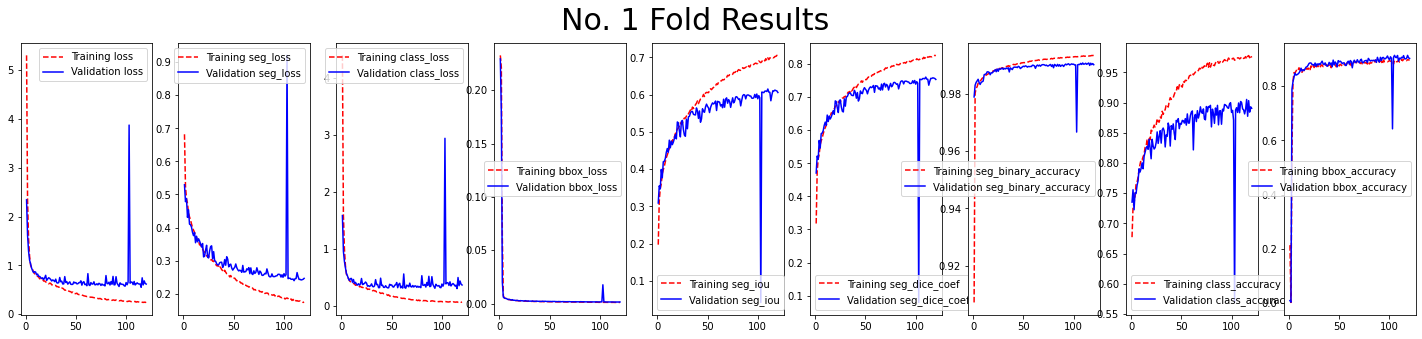

In [21]:
import pickle

for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])
                
    with open(str(h+1) + '_lungs_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [22]:
print('accuracies : ', accuracies)
print('losses : ', losses)
print('dicecoefs : ', dicecoefs)
print('ious : ', ious)

print('-----------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------')

print('average accuracy : ', np.mean(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)))
print('average dicecoefs : ', np.mean(np.array(dicecoefs)))
print('average ious : ', np.mean(np.array(ious)))
print()

print('standard deviation of accuracy : ', np.std(np.array(accuracies)))
print('standard deviation of loss : ', np.std(np.array(losses)))
print('standard deviation of dicecoefs : ', np.std(np.array(dicecoefs)))
print('standard deviation of ious : ', np.std(np.array(ious)))

accuracies :  [0.9907647371292114]
losses :  [0.24273566901683807]
dicecoefs :  [0.7572643160820007]
ious :  [0.6106671690940857]
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
average accuracy :  0.9907647371292114
average loss :  0.24273566901683807
average dicecoefs :  0.7572643160820007
average ious :  0.6106671690940857

standard deviation of accuracy :  0.0
standard deviation of loss :  0.0
standard deviation of dicecoefs :  0.0
standard deviation of ious :  0.0


1 538
[[0.99999356]] 71 61 23 30


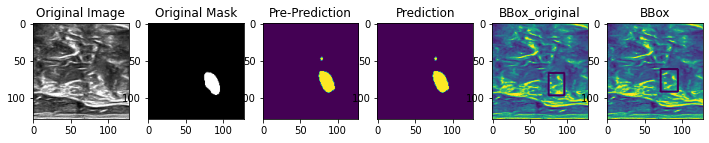

2 751
[[0.9629726]] 84 19 23 31


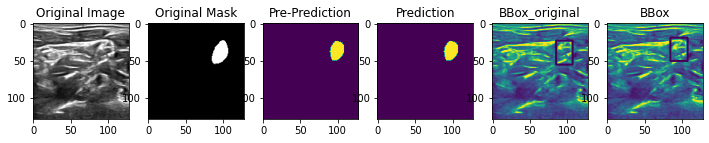

3 1706
[[0.97766966]] 58 28 23 31


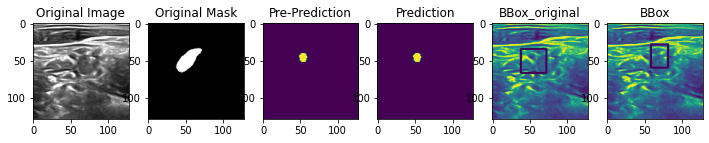

4 1171
[[0.00143957]] 54 23 18 35


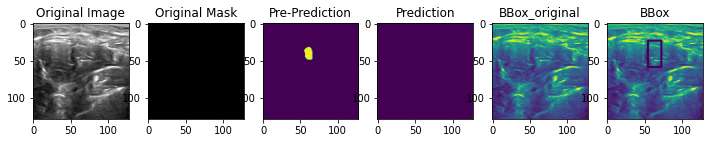

5 1416
[[0.98548317]] 46 28 21 36


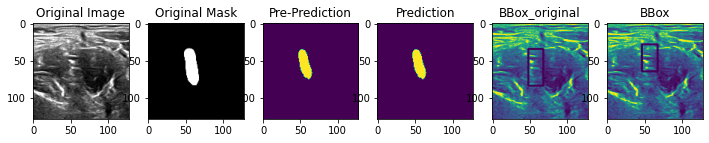

6 196
[[0.999506]] 78 18 15 30


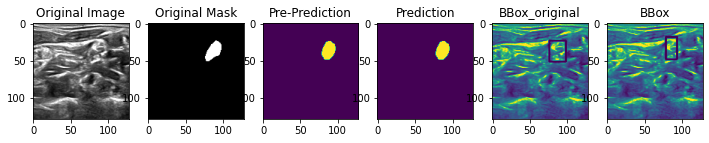

7 64
[[0.74949384]] 52 45 29 40


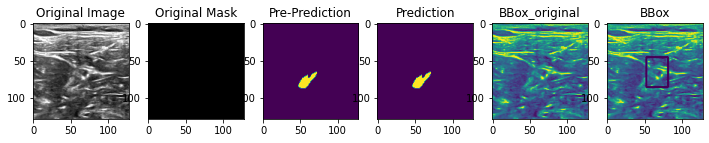

8 1411
[[0.9947584]] 59 25 18 40


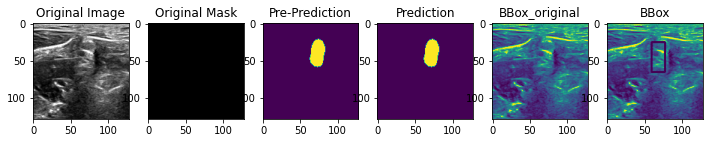

9 15
[[0.0065979]] 50 21 20 37


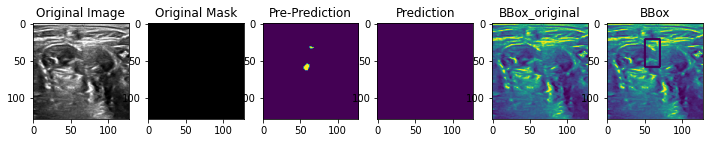

10 1822
[[1.]] 71 75 23 30


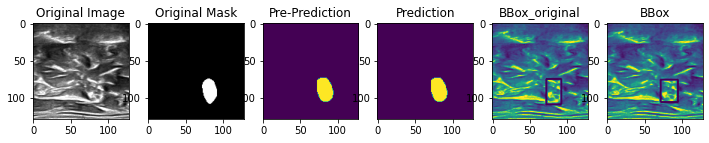

11 286
[[0.9910381]] 65 20 31 42


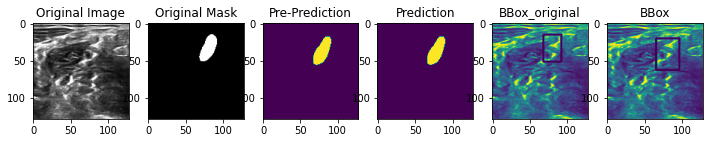

12 1953
[[0.9999999]] 75 74 17 33


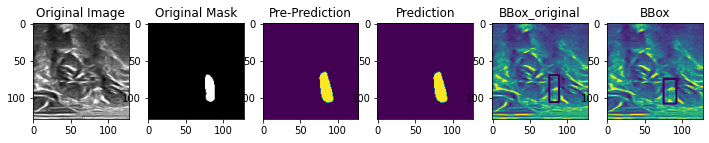

13 1821
[[1.]] 81 70 24 32


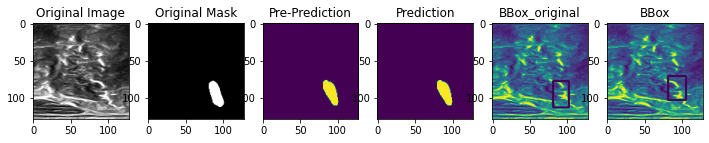

14 894
[[0.01124072]] 68 19 15 34


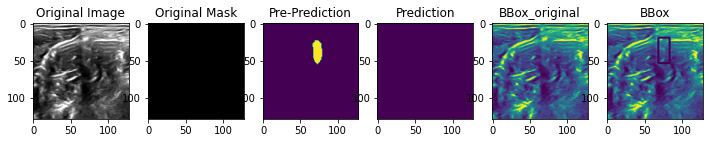

15 475
[[1.]] 71 62 18 35


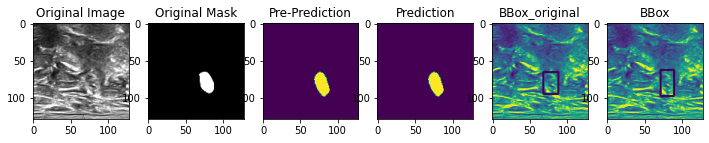

16 1659
[[0.29428086]] 61 20 23 32


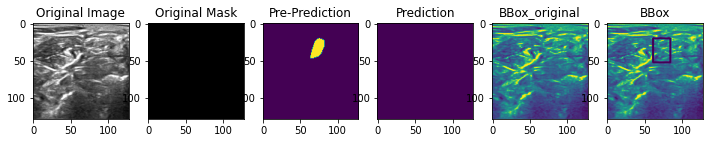

17 883
[[0.9974855]] 61 27 17 38


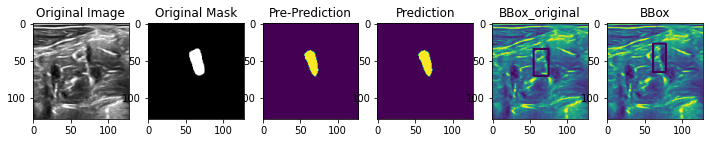

18 1377
[[0.00031228]] 55 55 20 35


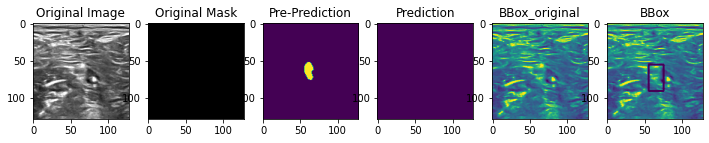

19 71
[[0.9999782]] 28 24 24 45


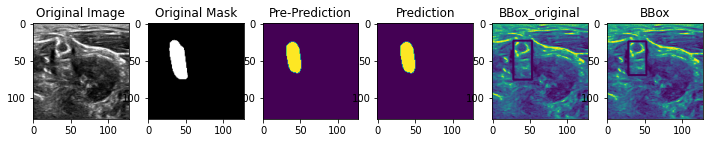

20 1271
[[0.00143676]] 61 26 18 30


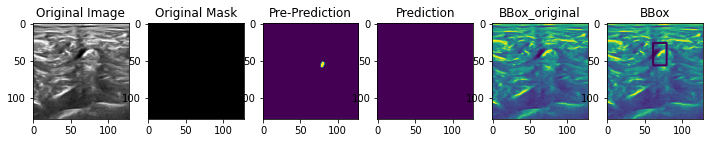

In [23]:
for i in range(20):
    index=np.random.randint(0,len(test_data_frame.index))
    print(i+1, index)
    img = cv2.imread(test_data_frame['filename'].iloc[index])
    img = cv2.resize(img, (height, width))
    img = preprocess_input(img)
    img = img[np.newaxis, :, :, :]
    pred = model.predict(img)
    pre_pred = Model(model.inputs, model.get_layer('pre').output).predict(img)

    m_ = np.array(cv2.resize(cv2.imread(test_data_frame['mask'].iloc[index], cv2.IMREAD_GRAYSCALE), (height, width)), dtype='uint8')
    _, thresh = cv2.threshold(m_,127,255,0)
    contours, _ = cv2.findContours(thresh, 1, 2)

    bbox = np.zeros(shape=4)
    if len(contours) > 0:
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)

        bbox[:] = x, y, w, h
        
#     Assuming height == width
    bbox /= height

    plt.figure(figsize=(12,12))
    plt.subplot(1,6,1)
    plt.imshow(cv2.resize(cv2.imread(test_data_frame['filename'].iloc[index]), (height, width)))
    plt.title('Original Image')
    plt.subplot(1,6,2)
    plt.imshow(np.squeeze(cv2.resize(cv2.imread(test_data_frame['mask'].iloc[index]), (height, width))))
    plt.title('Original Mask')
    plt.subplot(1,6,3)
    plt.imshow(np.squeeze(pre_pred) > .5)
    plt.title('Pre-Prediction')
    plt.subplot(1,6,4)
    plt.imshow(np.squeeze(pred[0]) > .5)
    plt.title('Prediction')
    x, y, w, h = np.array(bbox * height, dtype='int')
    bb = cv2.resize(cv2.imread(test_data_frame['filename'].iloc[index], cv2.IMREAD_GRAYSCALE), (height, width))
    bb = cv2.rectangle(bb, (x, y), (x+w, y+h), 1, 2)
    plt.subplot(1,6,5)
    plt.imshow(bb)
    plt.title('BBox_original')
    x, y, w, h = np.array(pred[2][0] * height, dtype='int')
    print(pred[1],x,y,w,h)
    bb = cv2.resize(cv2.imread(test_data_frame['filename'].iloc[index], cv2.IMREAD_GRAYSCALE), (height, width))
    bb = cv2.rectangle(bb, (x, y), (x+w, y+h), 1, 2)
    plt.subplot(1,6,6)
    plt.imshow(bb)
    plt.title('BBox')
    plt.show()

In [24]:
tp_cls = tp_seg = tn_cls = tn_seg = fp_cls = fp_seg = fn_cls = fn_seg = tp_mod = tn_mod = fp_mod = fn_mod = 0
# conf.shape = (gt_cls, cls_cls, seg_cls)
conf = np.zeros((2,2,2))
conf2 = np.zeros((2,2,2))

# gt = 0
# cls = 1
# seg = 2

false_negatives = [] 
false_positives = [] 

for i, j in tqdm(zip(train_image_polished, train_mask_polished)):
    img = cv2.imread(i)
    mask_img = cv2.imread(j)

    img = cv2.resize(img, (height, width))
    img = preprocess_input(img)
    img = img[np.newaxis, :, :, :]
    pred = model.predict(img)
    pre_pred = Model(model.inputs, model.get_layer('pre').output).predict(img)
    
    if(np.sum(mask_img >= 0.5) == 0):
        ground_truth = 0
    else:
        ground_truth = 1

    # Have to try moving the threshhold value
    if(pred[1] >= 0.5):
        cls_pred = 1
    else:
        cls_pred = 0

    if(np.sum(pred[0] >= 0.5) == 0):
        seg_pred = 0
    else:
        seg_pred = 1

    if(np.sum(pre_pred[0] >= 0.5) == 0):
        seg_pre_pred = 0
    else:
        seg_pre_pred = 1

    if(ground_truth == 1 and cls_pred == 1):
        tp_cls = tp_cls+1
    elif(ground_truth == 0 and cls_pred == 0):
        tn_cls = tn_cls+1
    elif(ground_truth == 1 and cls_pred == 0):
        fn_cls = fn_cls+1
    else:
        fp_cls = fp_cls+1
        
    if(ground_truth == 1 and seg_pred == 1):
        tp_seg = tp_seg+1
    elif(ground_truth == 0 and seg_pred == 0):
        tn_seg = tn_seg+1
    elif(ground_truth == 1 and seg_pred == 0):
        fn_seg = fn_seg+1
    else:
        fp_seg = fp_seg+1
        
    if(cls_pred == 1 and seg_pred == 1):
        tp_mod = tp_mod+1
    elif(cls_pred == 0 and seg_pred == 0):
        tn_mod = tn_mod+1
    elif(cls_pred == 1 and seg_pred == 0):
        fn_mod = fn_mod+1
        false_negatives.append((i,j))
    else:
        fp_mod = fp_mod+1
        
    if(seg_pre_pred == 1 and cls_pred == 0):
        false_positives.append((i,j))
        
    conf[ground_truth, cls_pred, seg_pred] += 1
    conf2[ground_truth, cls_pred, seg_pre_pred] += 1

5623it [21:56,  4.27it/s]


In [25]:
print('Modes\t', 'TP', 'TN', 'FP', 'FN', sep='\t')
print('Class\t', tp_cls, tn_cls, fp_cls, fn_cls, sep='\t')
print('Seg\t', tp_seg, tn_seg, fp_seg, fn_seg, sep='\t')
print('Seg wrt Class', tp_mod, tn_mod, fp_mod, fn_mod, sep='\t')

Modes		TP	TN	FP	FN
Class		2236	3073	231	83
Seg		2203	3091	213	116
Seg wrt Class	2416	3156	0	51


In [26]:
print('Pos examples:\n')
print(conf[1])
print('Neg exaples:\n')
print(conf[0])

Pos examples:

[[  83.    0.]
 [  33. 2203.]]
Neg exaples:

[[3073.    0.]
 [  18.  213.]]


In [27]:
print('Pos examples:\n')
print(conf2[1])
print('Neg exaples:\n')
print(conf2[0])

Pos examples:

[[  13.   70.]
 [  33. 2203.]]
Neg exaples:

[[1038. 2035.]
 [  18.  213.]]


In [28]:
!rm -r generated 